<a href="https://colab.research.google.com/github/avva14/ganx/blob/main/C1W1_Your_First_GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

In [2]:
tf.__version__

'2.7.0'

In [3]:
import tensorflow_datasets as tfds

In [4]:
import numpy as np
import matplotlib.pyplot as plt

In [5]:
from IPython import display

In [15]:
from tqdm.auto import tqdm

In [6]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [7]:
PATH_TO_TFDS = '/content/gdrive/MyDrive/tensorflow_datasets'

In [212]:
def plot_multiple_images(images, n_cols=None, title=None):
    '''visualizes fake images'''
    display.clear_output(wait=False)  
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1

    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)

    plt.figure(figsize=(n_cols, n_rows))
    if (title):
        plt.suptitle(title)
    
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

In [9]:
def map_image(image, label):
    '''Normalizes the image. Returns image as input and label.'''
    image = tf.pad(image, tf.constant([[2,2],[2,2],[0,0]]), "CONSTANT")
    image = tf.cast(image, dtype=tf.float32)
    image = image / 255.0

    return image

In [10]:
BATCH_SIZE = 256
SHUFFLE_BUFFER_SIZE = 1024

In [20]:
alle_dataset = tfds.load('fashion_mnist', data_dir=PATH_TO_TFDS, as_supervised=True, split="train")

In [21]:
train_dataset = alle_dataset.map(map_image)

In [22]:
train_dataset = train_dataset.shuffle(SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE)

In [18]:
train_dataset

<BatchDataset shapes: (None, None, 32, 32, 1), types: tf.float32>

In [25]:
for t in train_dataset.take(5):
    print(t.shape)

(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)
(256, 32, 32, 1)


In [26]:
random_normal_dimensions = 32
hidden_dim = 128

In [27]:
from keras.models import Model, Sequential
from keras.layers import Input, BatchNormalization, Dense, Reshape, Flatten
from keras.layers import ReLU, LeakyReLU

In [28]:
def genblock(input_tensor, n_filters, name):
    x = input_tensor
    x = Dense(n_filters, name=f'dense_block_{name}')(x)
    x = BatchNormalization(name=f'batch_block_{name}')(x)
    x = ReLU(name=f'relu_block_{name}')(x)
    return x

def generator(z_dim, hidden_dim):
    
    inputs = Input(shape=(z_dim), name='input')
    x = genblock(inputs, hidden_dim, '1')
    x = genblock(x, 2*hidden_dim, '2')
    x = genblock(x, 4*hidden_dim, '3')
    x = genblock(x, 8*hidden_dim, '4')
    x = Dense(32*32, activation='sigmoid', name='final')(x)
    outputs = Reshape((32,32,1), name='toimg')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='gen')

    return model

In [59]:
gener = generator(random_normal_dimensions, hidden_dim)
gener.summary()

Model: "gen"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32)]              0         
                                                                 
 dense_block_1 (Dense)       (None, 128)               4224      
                                                                 
 batch_block_1 (BatchNormali  (None, 128)              512       
 zation)                                                         
                                                                 
 relu_block_1 (ReLU)         (None, 128)               0         
                                                                 
 dense_block_2 (Dense)       (None, 256)               33024     
                                                                 
 batch_block_2 (BatchNormali  (None, 256)              1024      
 zation)                                                       

In [34]:
def discrblock(input_tensor, n_filters, name):
    '''
    Discriminator Block
    Function for returning a neural network of the discriminator given input and output dimensions.
    '''
    
    x = Dense(n_filters, name=f'block_{name}', activation=LeakyReLU(alpha=0.2))(input_tensor)
    return x

def discriminator(hidden_dim):
    
    inputs = Input(shape=(32,32,1), name='input')
    x = Flatten(name='flat')(inputs)
    x = discrblock(x, 4*hidden_dim, '1')
    x = discrblock(x, 2*hidden_dim, '2')
    x = discrblock(x, hidden_dim, '3')
    outputs = Dense(1, activation='sigmoid', name='final')(x)
    
    model = Model(inputs=inputs, outputs=outputs, name='discr')

    return model

In [58]:
discrim = discriminator(hidden_dim)
discrim.summary()

Model: "discr"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 32, 32, 1)]       0         
                                                                 
 flat (Flatten)              (None, 1024)              0         
                                                                 
 block_1 (Dense)             (None, 512)               524800    
                                                                 
 block_2 (Dense)             (None, 256)               131328    
                                                                 
 block_3 (Dense)             (None, 128)               32896     
                                                                 
 final (Dense)               (None, 1)                 129       
                                                                 
Total params: 689,153
Trainable params: 689,153
Non-trainable

In [36]:
discrim.predict(test_out).shape

(256, 1)

## Method 1

In [129]:
gan = Sequential([gener, discrim])

In [130]:
discrim.compile(loss="binary_crossentropy", optimizer="rmsprop")
discrim.trainable = False
gan.compile(loss="binary_crossentropy", optimizer="rmsprop")

In [127]:
def train_gan(gan, dataset, n_epochs=5):
    """ Defines the two-phase training loop of the GAN
    Args:
      gan -- the GAN model which has the generator and discriminator
      dataset -- the training set of real images
      random_normal_dimensions -- dimensionality of the input to the generator
      n_epochs -- number of epochs
    """

    # get the two sub networks from the GAN model
    generator, discriminator = gan.layers

    # start loop
    for epoch in range(n_epochs):
               
        for real_images in dataset:
            # infer batch size from the training batch
            batch_size = real_images.shape[0]

            # Train the discriminator - PHASE 1
            # Create the noise
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])
            
            # Use the noise to generate fake images
            fake_images = generator(noise)
            
            # Create a list by concatenating the fake images with the real ones
            mixed_images = tf.concat([fake_images, real_images], axis=0)
            
            # Create the labels for the discriminator
            # 0 for the fake images
            # 1 for the real images
            discriminator_labels = tf.constant([[0.]] * batch_size + [[1.]] * batch_size)
            
            # Ensure that the discriminator is trainable
            discriminator.trainable = True
            
            # Use train_on_batch to train the discriminator with the mixed images and the discriminator labels
            discriminator.train_on_batch(mixed_images, discriminator_labels)
            
            # Train the generator - PHASE 2
            # create a batch of noise input to feed to the GAN
            noise = tf.random.normal(shape=[batch_size, random_normal_dimensions])

            # label all generated images to be "real"
            generator_labels = tf.constant([[1.]] * batch_size)

            # Freeze the discriminator
            discriminator.trainable = False

            # Train the GAN on the noise with the labels all set to be true
            gan.train_on_batch(noise, generator_labels)

        # plot the fake images used to train the discriminator
        plot_multiple_images(fake_images[:24], 8, f"Epoch {epoch + 1}/{n_epochs}")                     
        plt.show()

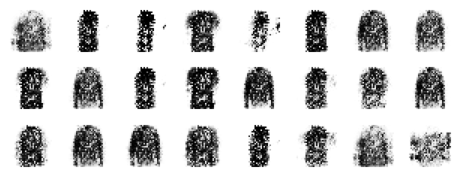

Epoch 5/5


In [131]:
train_gan(gan, train_dataset)

# Method 2

In [190]:
gener = generator(random_normal_dimensions, hidden_dim)
discrim = discriminator(hidden_dim)

In [204]:
bce_loss = tf.keras.losses.BinaryCrossentropy(from_logits=False)
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
n_epochs = 5

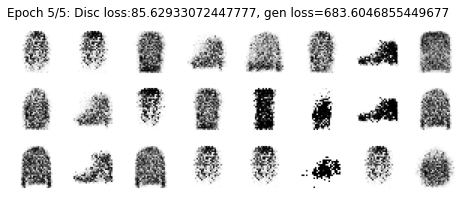

In [215]:
for epoch in range(n_epochs):
    gloss = 0
    dloss = 0
    for reals in tqdm(train_dataset):
        cur_batch_size = len(reals)
        
        with tf.GradientTape() as disc_tape, tf.GradientTape() as gen_tape:

            noise = tf.random.normal(shape=[cur_batch_size, random_normal_dimensions])
            fakes = gener(noise, training=True)
            disc_fake_labels = discrim(fakes, training=True)
            disc_real_labels = discrim(reals, training=True)

            gen_loss = bce_loss(tf.ones_like(disc_fake_labels), disc_fake_labels)
            disc_loss = bce_loss(tf.zeros_like(disc_fake_labels), disc_fake_labels) + bce_loss(tf.ones_like(disc_real_labels), disc_real_labels)

        disc_grads = disc_tape.gradient(disc_loss, discrim.trainable_weights)
        gen_grads = gen_tape.gradient(gen_loss, gener.trainable_weights)

        optimizer.apply_gradients(zip(disc_grads, discrim.trainable_weights))
        optimizer.apply_gradients(zip(gen_grads, gener.trainable_weights))
        dloss += disc_loss.numpy()
        gloss += gen_loss.numpy()

    plot_multiple_images(fakes[:24], 8, f'Epoch {epoch+1}/{n_epochs}: Disc loss:{dloss}, gen loss={gloss}')                     
    plt.show()